In [3]:
import tensorflow as tf
from glob import glob
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.applications import resnet
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

# Dataset
## Get

In [4]:
IMG_TARGET_SIZE = (224, 224)
DATA_FOLDER = "data/Image_Classification/dataset_25061716"

dataset = []
labels = []
labels_name = []

classes = glob(DATA_FOLDER + "/*")

# get all classes
for class_idx, class_folder in tqdm(list(enumerate(classes))):
    labels_name.append(class_folder.split("/")[-1])
    
    # get all images in class folder
    for image_file in glob(class_folder + "/*.jpg"):
        image = cv2.imread(image_file)
        image = cv2.resize(image, IMG_TARGET_SIZE)
        
        dataset.append(image)
        
        # hot encoding labels
        label = np.zeros(len(classes))
        label[class_idx] = 1
        labels.append(label)

dataset = np.array(dataset)
labels = np.array(labels)

print(f"data shape: {dataset.shape}, labels shape: {labels.shape}")

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

data shape: (3248, 224, 224, 3), labels shape: (3248, 20)


## Split

In [5]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.3, random_state=25061716)
test_dataset, val_dataset, test_labels, val_labels = train_test_split(test_dataset, test_labels, test_size=0.3, random_state=25061716)

print(f"train data shape: {train_dataset.shape}, train labels shape: {train_labels.shape}")
print(f"test data shape: {test_dataset.shape}, test labels shape: {test_labels.shape}")
print(f"val data shape: {val_dataset.shape}, val labels shape: {val_labels.shape}")

train data shape: (2273, 224, 224, 3), train labels shape: (2273, 20)
test data shape: (682, 224, 224, 3), test labels shape: (682, 20)
val data shape: (293, 224, 224, 3), val labels shape: (293, 20)


# Model Resnet50

In [5]:
model = resnet.ResNet50(include_top=True, weights=None, input_shape=(IMG_TARGET_SIZE[0], IMG_TARGET_SIZE[1], 3), classes=len(classes))
print(model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Training

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, train_labels, validation_data=(val_dataset, val_labels), epochs=200, batch_size=32)

Epoch 1/200
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2024-05-02 08:14:06.804 tensorflow-2-6-gpu--ml-g4dn-xlarge-c97c437bb7a567fed6fc3e40998a:35 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-05-02 08:14:06.830 tensorflow-2-6-gpu--ml-g4dn-xlarge-c97c437bb7a567fed6fc3e40998a:35 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
72/72 [==============================] - 35s 341ms/step - loss: 3.1670 - accuracy: 0.1751 - val_loss: 3.3500 - val_accuracy: 0.0819
Epoch 2/200
72/72 [==============================] - 22s 302ms/step - loss: 2.4350 - accuracy: 0.2657 - val_loss: 2.9002 - val_accuracy: 0.1638
Epoch 3/200
72/72 [===

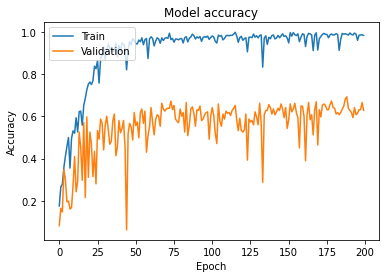

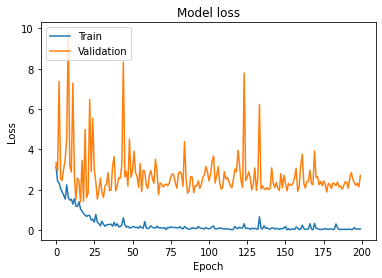

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
model.save("models/model.h5")

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Results

In [11]:
def compute_accuracies(model):
    true_train_labels = np.argmax(train_labels, axis=1)
    predicted_train_labels = model.predict(train_dataset).argmax(axis=1)
    train_accuracy = accuracy_score(true_train_labels, predicted_train_labels)
    
    true_test_labels = np.argmax(test_labels, axis=1)
    predicted_test_labels = model.predict(test_dataset).argmax(axis=1)
    test_accuracy = accuracy_score(true_test_labels, predicted_test_labels)
    
    true_val_labels = np.argmax(val_labels, axis=1)
    predicted_val_labels = model.predict(val_dataset).argmax(axis=1)
    val_accuracy = accuracy_score(true_val_labels, predicted_val_labels)
    
    return train_accuracy, test_accuracy, val_accuracy

In [11]:
train_accuracy, test_accuracy, val_accuracy = compute_accuracies(model)

print(f"{train_accuracy = }, {test_accuracy = }, {val_accuracy = }")

train_accuracy = 0.9819621645402552, test_accuracy = 0.6055718475073314, val_accuracy = 0.6279863481228669


# Model Upgraded

In [19]:
model = resnet.ResNet50(include_top=True, weights=None, input_shape=(IMG_TARGET_SIZE[0], IMG_TARGET_SIZE[1], 3), classes=len(classes))
config = model.get_config()

# (i, j) : i-th convolutional layer, j-th block
layers_to_remove = [
    (2, 3),
    (3, 4),
    (4, 6), (4, 5),
    (5, 3)
]

for conv, block in sorted(layers_to_remove, reverse=True):
    # Info about the layer to remove
    layer_to_remove = f"conv{conv}_block{block}"
    layer_to_remove_input = [layer for layer in config["layers"] if layer["name"] == f"conv{conv}_block{block}_1_conv"][0]["inbound_nodes"][0][0]
    
    # Remove the layer from the config
    config["layers"] = [layer for layer in config["layers"] if not layer["name"].startswith(layer_to_remove)]
    
    if conv < 5:
        next_layer_name = f"conv{conv + 1}_block1"
        next_layer = {layer["name"]: layer for layer in config["layers"] if layer["name"].startswith(next_layer_name)}
        
        # Connect the previous layer to the next layer
        next_layer[next_layer_name + "_0_conv"]["inbound_nodes"][0][0] = layer_to_remove_input
        next_layer[next_layer_name + "_1_conv"]["inbound_nodes"][0][0] = layer_to_remove_input
    else:
        next_layer = [layer for layer in config["layers"] if layer["name"] == "avg_pool"][0]
        
        # Connect the previous layer to the next layer
        next_layer["inbound_nodes"][0][0] = layer_to_remove_input


# Create the new model
model = Model.from_config(config)

print(model.summary())

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Training

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, train_labels, validation_data=(val_dataset, val_labels), epochs=100, batch_size=32)

Epoch 1/100
72/72 [==============================] - 20s 227ms/step - loss: 3.0780 - accuracy: 0.1742 - val_loss: 81.9171 - val_accuracy: 0.0307
Epoch 2/100
72/72 [==============================] - 16s 219ms/step - loss: 2.3087 - accuracy: 0.2873 - val_loss: 4.9254 - val_accuracy: 0.0922
Epoch 3/100
72/72 [==============================] - 16s 220ms/step - loss: 2.0291 - accuracy: 0.3775 - val_loss: 3.7345 - val_accuracy: 0.1160
Epoch 4/100
72/72 [==============================] - 16s 221ms/step - loss: 1.9843 - accuracy: 0.3951 - val_loss: 9.0753 - val_accuracy: 0.0785
Epoch 5/100
72/72 [==============================] - 16s 221ms/step - loss: 1.7290 - accuracy: 0.4536 - val_loss: 4.2442 - val_accuracy: 0.2833
Epoch 6/100
72/72 [==============================] - 16s 221ms/step - loss: 1.5149 - accuracy: 0.5253 - val_loss: 8.9190 - val_accuracy: 0.1331
Epoch 7/100
72/72 [==============================] - 16s 221ms/step - loss: 1.4413 - accuracy: 0.5407 - val_loss: 3.3021 - val_accuracy

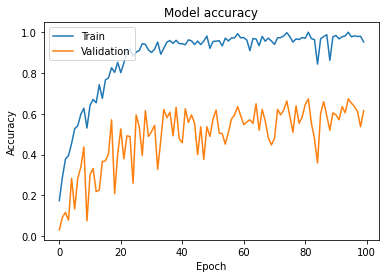

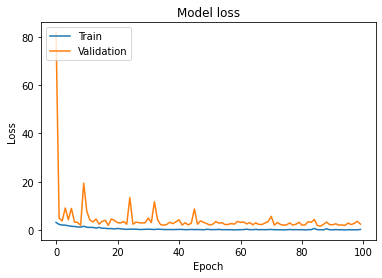

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.save("models/reduced_model.h5")

## Results

In [25]:
train_accuracy, test_accuracy, val_accuracy = compute_accuracies(model)

print(f"{train_accuracy = }, {test_accuracy = }, {val_accuracy = }")

train_accuracy = 0.915530136383634, test_accuracy = 0.5601173020527859, val_accuracy = 0.6143344709897611
